In [136]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler,Normalizer
from numpy import nan
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [137]:
movie_df = pd.read_csv('data/data_regression.csv')

In [138]:
movie_df = movie_df.drop(columns=['director_name','imdb_id','plot_keywords', 'genres','actor_2_name', 'actor_1_name', 'actor_3_name','language', 'country', 'movie_title', 'title_year'])
movie_df.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank', 'gross_budget_ratio'],
      dtype='object')

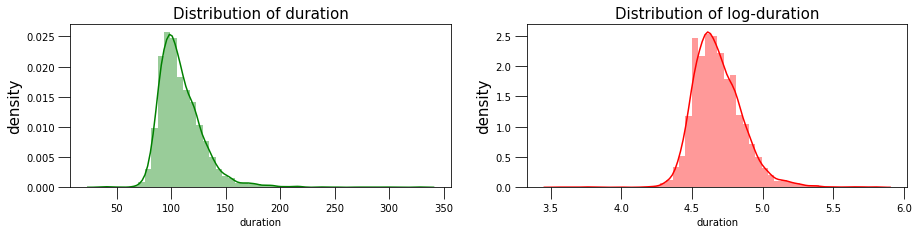

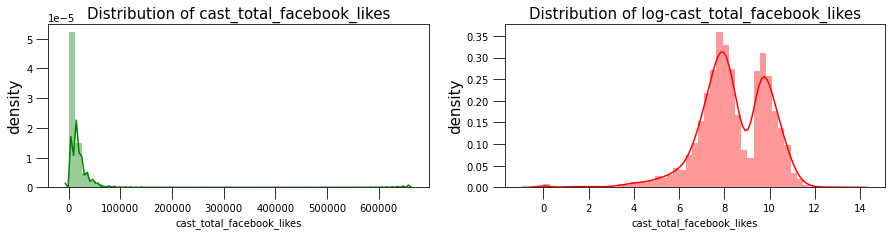

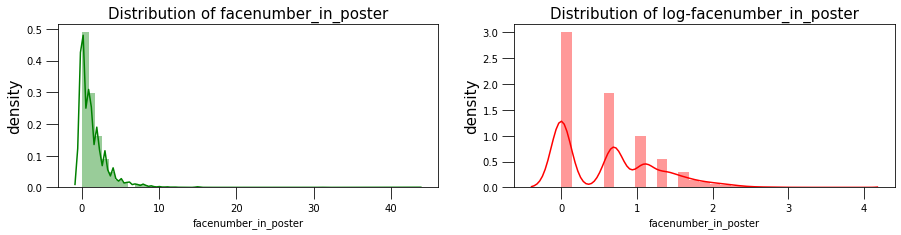

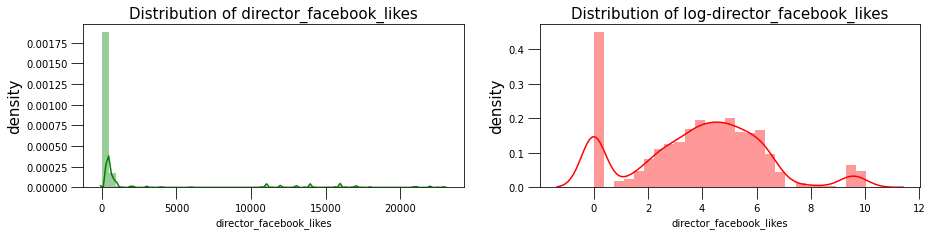

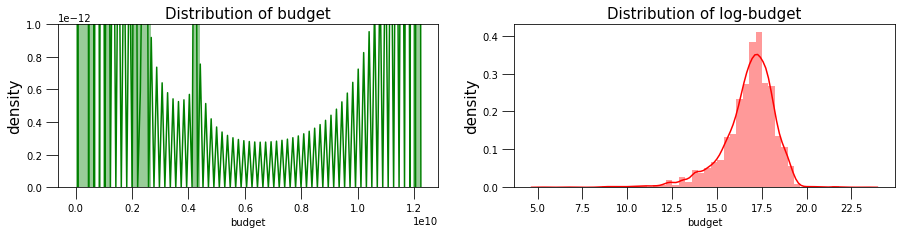

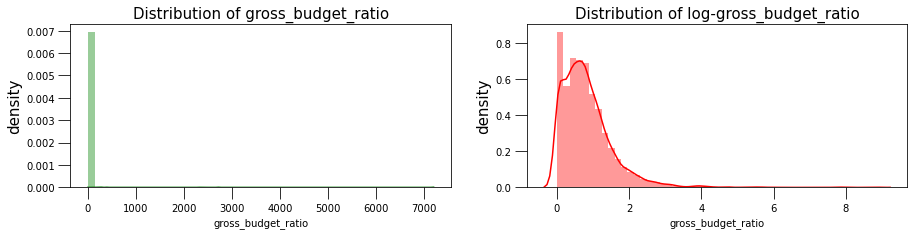

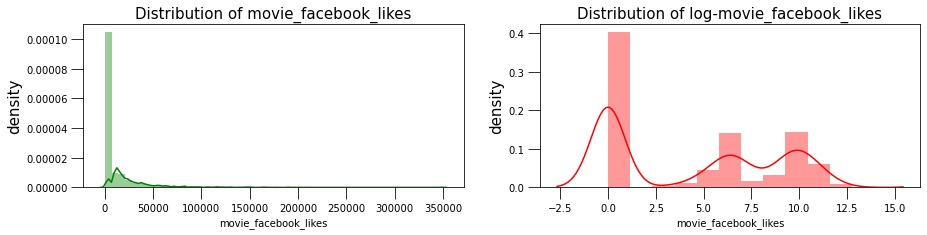

In [139]:
for col in ['duration', 'cast_total_facebook_likes', 'facenumber_in_poster', 'director_facebook_likes',
       'budget','gross_budget_ratio', 'movie_facebook_likes']:
    
    _, (ax1, ax2) = plt.subplots(figsize=(15,3), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

From these plots we see that for duration, cast facebook likes, director  facebook likes, budget and gross_budget ratio it is better to use the log version and use the normalization to scalar.

In [140]:
# use the log

#substitude 0 with 1
movie_df.cast_total_facebook_likes = [ 1 if x==0 else x for x in movie_df.cast_total_facebook_likes ]
movie_df.director_facebook_likes = [ 1 if x==0 else x for x in movie_df.director_facebook_likes ]
movie_df.movie_facebook_likes = [ 1 if x==0 else x for x in movie_df.director_facebook_likes ]
movie_df.actor_1_facebook_likes = [ 1 if x==0 else x for x in movie_df.actor_1_facebook_likes ]
movie_df.actor_2_facebook_likes = [ 1 if x==0 else x for x in movie_df.actor_2_facebook_likes ]
movie_df.actor_3_facebook_likes = [ 1 if x==0 else x for x in movie_df.actor_3_facebook_likes ]

for col in ['duration', 'cast_total_facebook_likes','director_facebook_likes', 'budget','gross_budget_ratio', 'movie_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']:
    name = 'log_' + col
    movie_df[name] = np.log(movie_df[col])

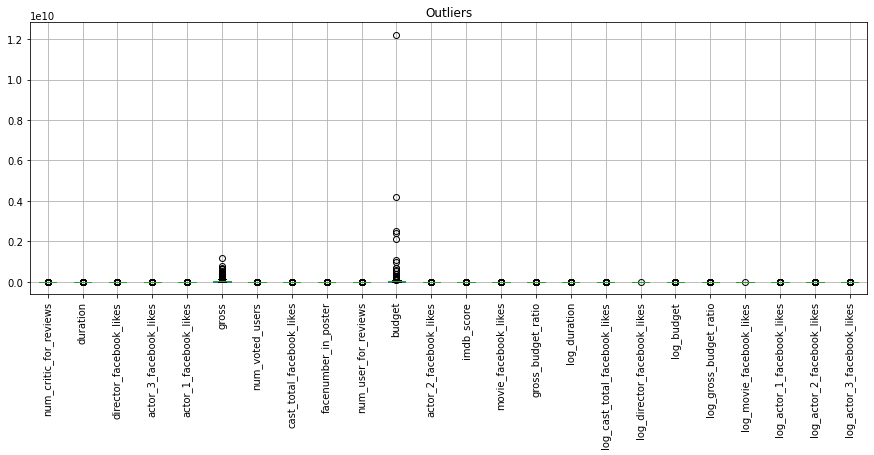

In [141]:
# show outlayers ( we don't plot variables which are between 0 and 10 for construction)
(ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=1)
movie_df.drop(columns=['Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others','director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']).boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

In [142]:
# We cut out outliers

movie_df = movie_df[(np.abs(stats.zscore(movie_df['facenumber_in_poster'], nan_policy='omit')) < 2)]
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_cast_total_facebook_likes'], nan_policy='omit')) < 2)]

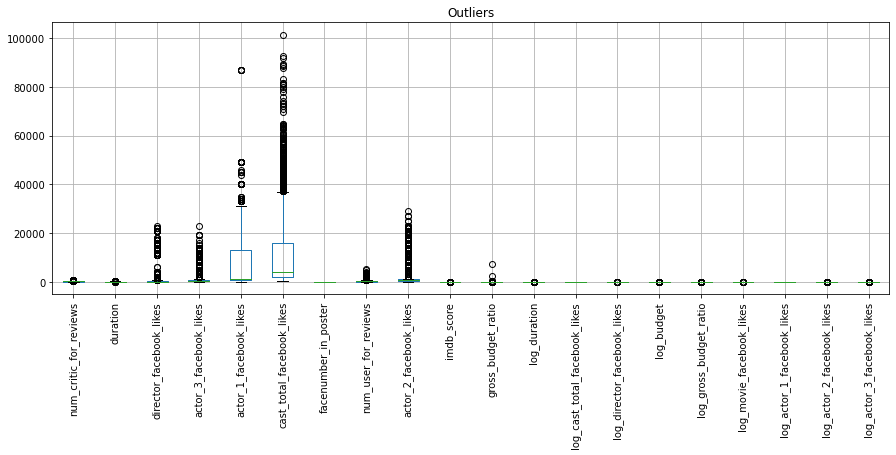

In [143]:
# show outlayers without gross and budget
(ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=1)
movie_df.drop(columns=['gross', 'budget', 'num_voted_users','Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others','director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank','movie_facebook_likes']).boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

## not log: normal features

this is done to show that it works worse than log version

In [9]:
# movie_df = movie_df[movie_df['gross'].isna() == False]
movie_df = movie_df[(movie_df['gross_budget_ratio'] <= 10) & (movie_df['budget'] >= 500000)]

# cut outlayers
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_budget'], nan_policy='omit')) < 3)]
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_gross_budget_ratio'], nan_policy='omit')) < 3)]

X = movie_df[['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_df['gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,duration,cast_total_facebook_likes,facenumber_in_poster,budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
0,123.0,22209,1.0,4.800000e+07,0,1,0,0,1,0,1,0,0,0,0,8,6,3,4
3,148.0,2566,1.0,2.700000e+07,0,1,1,0,0,0,0,0,1,0,1,8,3,3,4
4,98.0,14921,3.0,6.000000e+06,0,1,0,0,0,0,0,0,0,0,1,7,7,3,5
5,124.0,1462,0.0,2.000000e+07,1,1,0,0,0,0,0,0,0,0,1,5,3,2,3
6,124.0,2667,0.0,5.166449e+07,1,0,0,1,0,0,0,0,0,0,1,7,3,4,4


In [10]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['duration','budget']])

a = normalizer.transform(X[['duration','budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2328, 21)
Dimensionality of X_test : (999, 21)
Dimensionality of y_train: (2328,)
Dimensionality of y_test : (999,)


In [11]:
X.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank'],
      dtype='object')

In [14]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [2, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [15]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1}

In [16]:
#score
print(clf.best_score_)

#exp(score) because we are predictiong log ratio
np.exp(np.abs(clf.best_score_))

-2.3663236756059525


10.658137400958521

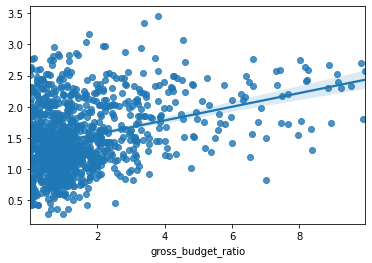

In [17]:
sns.regplot(y_test, clf.predict(X_test))

It is really bad, so we try with log

### LOG

Working with Log we obtain better results

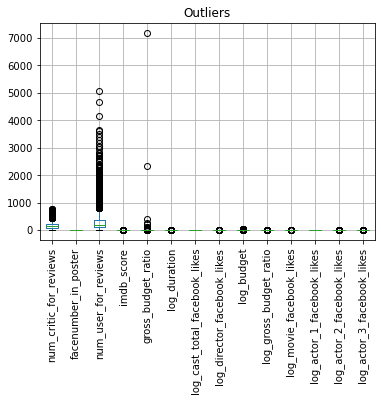

In [144]:
movie_log_df = movie_df.drop(columns=['movie_facebook_likes', 'budget', 'cast_total_facebook_likes', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'])

movie_log_df.drop(columns=['gross', 'num_voted_users','Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others','director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']).boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

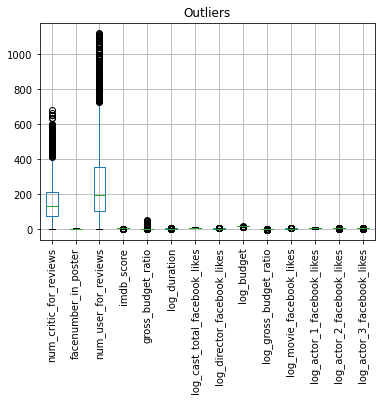

In [145]:
# cut Outliers
movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['log_budget'], nan_policy='omit')) < 3)]
#movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['actor_1_facebook_likes'], nan_policy='omit')) < 1.8)]
#movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['actor_2_facebook_likes'], nan_policy='omit')) < 3)]
#movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['actor_3_facebook_likes'], nan_policy='omit')) < 3)]
movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['num_user_for_reviews'], nan_policy='omit')) < 2)]
movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['log_budget'], nan_policy='omit')) < 3)]
movie_log_df = movie_log_df[(np.abs(stats.zscore(movie_log_df['log_gross_budget_ratio'], nan_policy='omit')) < 3)]

movie_log_df.drop(columns=['gross', 'num_voted_users','Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others','director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']).boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

In [146]:
X = movie_log_df[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_log_df['log_gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,log_duration,log_cast_total_facebook_likes,facenumber_in_poster,log_budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
0,4.812184,10.008253,1.0,17.686712,0,1,0,0,1,0,1,0,0,0,0,8,6,3,4
1,4.477337,7.910591,0.0,15.068274,0,1,0,0,0,0,0,0,0,0,0,8,2,3,4
2,4.644391,7.415777,0.0,15.319588,0,0,0,1,1,0,0,0,1,0,0,7,3,3,3
3,4.997212,7.850104,1.0,17.111347,0,1,1,0,0,0,0,0,1,0,1,8,3,3,4
4,4.584967,9.610525,3.0,15.607270,0,1,0,0,0,0,0,0,0,0,1,7,7,3,5


In [147]:
# normalization: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
           'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
           'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
           'Action_Adventure', 'History_War', 'Others', 'director_rank',
           'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget']])

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]


X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2293, 19)
Dimensionality of X_test : (984, 19)
Dimensionality of y_train: (2293,)
Dimensionality of y_test : (984,)


In [38]:
params = {
    'n_estimators': [60, 100, 200],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.02, 0.05],
    'subsample': [0.6, 0.9]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [39]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

In [40]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.5020229093175128


4.490764297002161

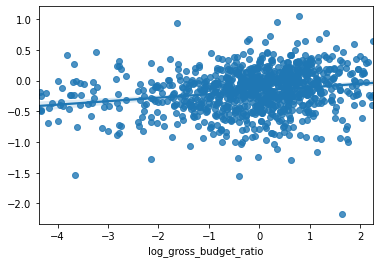

In [41]:
sns.regplot(y_test, clf.predict(X_test))

This is already a big improvements respect to the not log version

In [42]:
best_clf = XGBRegressor(**clf.best_params_)
best_clf.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':best_clf.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
5,Comedy,0.089603
7,Drama,0.070239
13,History_War,0.066147
0,log_duration,0.066004
17,actor2_rank,0.065986
4,Biography,0.065861
1,log_cast_total_facebook_likes,0.058820
9,Mystery_Thriller_Horror,0.057713
3,log_budget,0.056980
2,facenumber_in_poster,0.055882


### Drop Actor 3 Rank

In [43]:

X = movie_log_df[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank']]

y = movie_log_df['log_gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,log_duration,log_cast_total_facebook_likes,facenumber_in_poster,log_budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank
0,4.812184,10.008253,1.0,17.686712,0,1,0,0,1,0,1,0,0,0,0,8,6,3
3,4.997212,7.850104,1.0,17.111347,0,1,1,0,0,0,0,0,1,0,1,8,3,3
4,4.584967,9.610525,3.0,15.607270,0,1,0,0,0,0,0,0,0,0,1,7,7,3
5,4.820282,7.287561,0.0,16.811243,1,1,0,0,0,0,0,0,0,0,1,5,3,2
6,4.820282,7.888710,0.0,17.760281,1,0,0,1,0,0,0,0,0,0,1,7,3,4


In [44]:
# normalization: some columns prefer the normalization 

scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
           'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
           'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
           'Action_Adventure', 'History_War', 'Others', 'director_rank',
           'actor1_rank', 'actor2_rank']]))

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2193, 18)
Dimensionality of X_test : (940, 18)
Dimensionality of y_train: (2193,)
Dimensionality of y_test : (940,)


In [45]:
X.columns

Index(['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank'],
      dtype='object')

In [46]:
params = {
     'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.8, 1]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [47]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

In [48]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.4969450138120597


4.4680184645177645

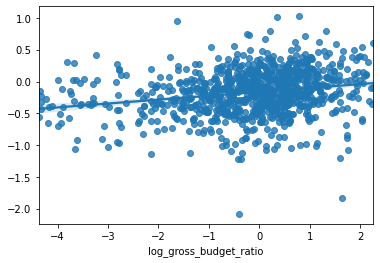

In [49]:
sns.regplot(y_test, clf.predict(X_test))

a bit better but nìnoting of significant

## regression only drama

**with other genres as features**
indeed a movie can have more genres

In [50]:
movie_drama = movie_log_df[movie_log_df.Drama==1]
movie_drama.head()

,num_critic_for_reviews,gross,num_voted_users,facenumber_in_poster,num_user_for_reviews,content_rating,imdb_score,Biography,Comedy,Crime,...,gross_budget_ratio,log_duration,log_cast_total_facebook_likes,log_director_facebook_likes,log_budget,log_gross_budget_ratio,log_movie_facebook_likes,log_actor_1_facebook_likes,log_actor_2_facebook_likes,log_actor_3_facebook_likes
6,46.0,79900000.0,12974,0.0,84.0,PG,7.5,1,0,0,...,1.546517,4.820282,7.888710,5.010635,17.760281,0.436005,5.010635,6.773080,6.704414,6.349139
8,117.0,26010864.0,161972,1.0,356.0,PG,8.2,1,0,0,...,5.202173,4.820282,9.537051,0.000000,15.424948,1.649076,0.000000,9.392662,6.625392,6.113682
11,102.0,1500000.0,9830,0.0,189.0,R,6.8,0,0,0,...,0.034091,5.783825,9.564863,6.248043,17.599700,-3.378725,6.248043,9.392662,6.744059,6.519147
12,62.0,54800000.0,35130,3.0,283.0,R,7.8,0,0,0,...,9.133333,4.820282,8.541300,0.000000,15.607270,2.211931,0.000000,7.600902,6.315358,6.282267
15,32.0,7000000.0,2933,0.0,70.0,PG,4.7,0,0,0,...,0.194444,4.779123,7.540622,1.609438,17.399029,-1.637609,1.609438,6.255750,5.918894,5.517453


In [51]:
X = movie_drama[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_drama['log_gross_budget_ratio']


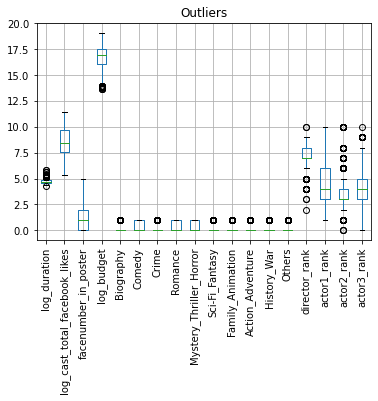

In [52]:
X.boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

In [53]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
       'Biography', 'Comedy', 'Crime', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget']])

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1111, 18)
Dimensionality of X_test : (477, 18)
Dimensionality of y_train: (1111,)
Dimensionality of y_test : (477,)


In [54]:
"""params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.6, 0.8, 1]
}
"""
params = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.6, 0.8]
}


clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

In [55]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.7406760915324724


5.701196650738305

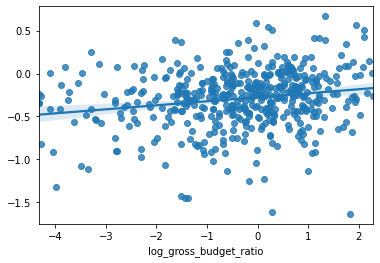

In [56]:
sns.regplot(y_test, clf.predict(X_test))

there are some outliers that disturb the result. Indeed, the graph is better than considering all the genres, while the error is bigger.

we have to detect and delete them

We cut out outliers

**without other genres as features**

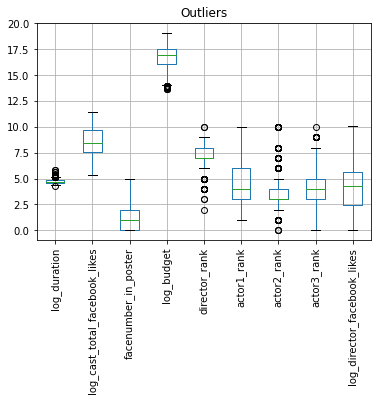

In [58]:
X = movie_drama[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_drama['log_gross_budget_ratio']

X.boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

In [59]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget']])

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1111, 8)
Dimensionality of X_test : (477, 8)
Dimensionality of y_train: (1111,)
Dimensionality of y_test : (477,)


In [60]:
"""params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.6, 0.8]
}"""

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.4, 0.6]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

In [61]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.7559392019302174


5.788882118828483

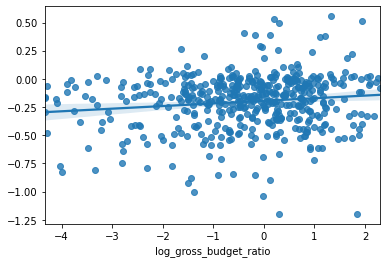

In [62]:
sns.regplot(y_test, clf.predict(X_test))

Cutting out other genre the regression is worse in terms of score, but the plot is better. Nothing of significant in both cases, then, once we identified a genre, include also the others it is not relevent

### drop facenumber in posters

In [82]:
X = movie_drama[['log_duration', 'log_cast_total_facebook_likes',
       'log_budget', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_drama['log_gross_budget_ratio']

In [83]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget']])

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1111, 7)
Dimensionality of X_test : (477, 7)
Dimensionality of y_train: (1111,)
Dimensionality of y_test : (477,)


In [84]:
params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.8]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

In [85]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.744119615622484


5.7208626995703735

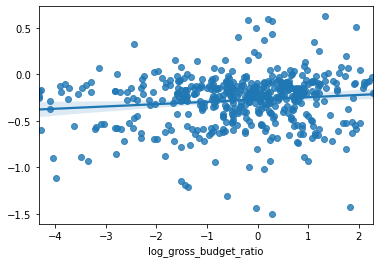

In [86]:
sns.regplot(y_test, clf.predict(X_test))

In [87]:
best_clf = XGBRegressor(**clf.best_params_)
best_clf.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':best_clf.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
1,log_cast_total_facebook_likes,0.213573
0,log_duration,0.181306
5,actor2_rank,0.173186
4,actor1_rank,0.162837
3,director_rank,0.145699
2,log_budget,0.123399
6,actor3_rank,0.000000


without face poster the regression improves!

### Add director facebook likes 
We try to add this feature, in the log version. There are a lot of zeros, so we substitude them with NaN because the algorithm is able to handle them

In [126]:

X = movie_drama[['log_duration', 'log_cast_total_facebook_likes',
       'log_budget', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank','log_director_facebook_likes']]

mean_nonzero_likes = np.mean(list(movie_drama.log_director_facebook_likes[movie_drama.log_director_facebook_likes>0]))

log_director = [ mean_nonzero_likes if x==0 else x for x in movie_drama.log_director_facebook_likes]

X['log_director_facebook_likes'] = log_director

y = movie_drama['log_gross_budget_ratio']


C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [127]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[[ 'log_cast_total_facebook_likes',
       'log_budget', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget', 'log_director_facebook_likes']])

a = normalizer.transform(X[['log_duration','log_budget', 'log_director_facebook_likes']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]
scaled_X['log_director_facebook_likes'] = a[:,2]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1111, 9)
Dimensionality of X_test : (477, 9)
Dimensionality of y_train: (1111,)
Dimensionality of y_test : (477,)


In [129]:
params = {
    'n_estimators': [200, 300],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.4, 0.8]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.4}

In [135]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.7258640151853335


5.617372428630184

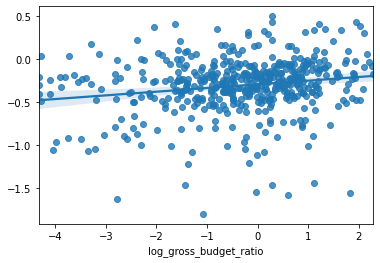

In [131]:
sns.regplot(y_test, clf.predict(X_test))

## Classification

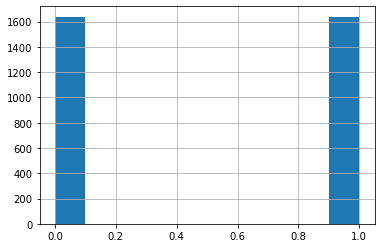

In [148]:
X_data = movie_log_df.drop(columns=['log_gross_budget_ratio','gross','gross_budget_ratio', 'content_rating'])
#y = pd.cut(movie_log_df['log_gross_budget_ratio'], bins=2, labels=False)
y = pd.qcut(movie_log_df['log_gross_budget_ratio'], q=2, labels=False)

y.hist()

Test score: 0.7154471544715447
Test accuracy: 0.7154471544715447


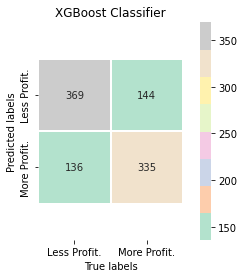

In [149]:
#prediction and Classification Report
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.3, random_state=7)

model1 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

train_model1 = model1.fit(X_train, y_train)

pred1 = train_model1.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score

print(f"Test score: {f1_score(y_test, pred1, average='micro')}")
print(f"Test accuracy: {accuracy_score(y_test, pred1)}")

ax = plt.subplot()
Model_Confusion_Matrix = confusion_matrix(pred1,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Less Profit.","More Profit."])
ax.yaxis.set_ticklabels(["Less Profit.","More Profit."], va="center")
b, t = plt.ylim() 
b += .5
t -= 0.5
plt.ylim(b, t)
plt.title('XGBoost Classifier')
plt.show()

To improve the classification, we can work on features

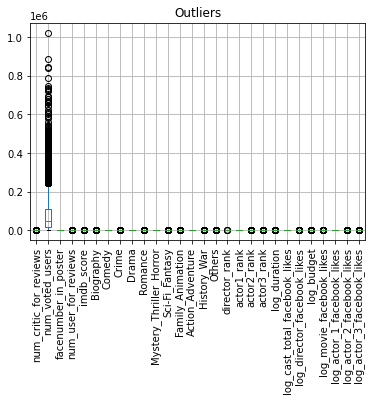

In [150]:
X_data.boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

drop num_voted_users

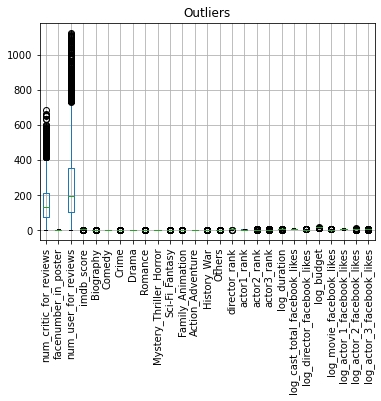

In [151]:
X_data_no_num_voted_users = X_data.drop(columns=['num_voted_users'])
X_data_no_num_voted_users.boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

Test score: 0.6839430894308943
Test accuracy: 0.6839430894308943


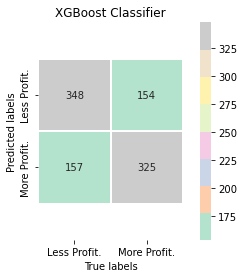

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no_num_voted_users, y, test_size=0.3, random_state=7)

model1 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

train_model1 = model1.fit(X_train, y_train)

pred1 = train_model1.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score

print(f"Test score: {f1_score(y_test, pred1, average='micro')}")
print(f"Test accuracy: {accuracy_score(y_test, pred1)}")

ax = plt.subplot()
Model_Confusion_Matrix = confusion_matrix(pred1,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Less Profit.","More Profit."])
ax.yaxis.set_ticklabels(["Less Profit.","More Profit."], va="center")
b, t = plt.ylim() 
b += .5
t -= 0.5
plt.ylim(b, t)
plt.title('XGBoost Classifier')
plt.show()

No! It was better before! Mybe we can only cut outlayers:

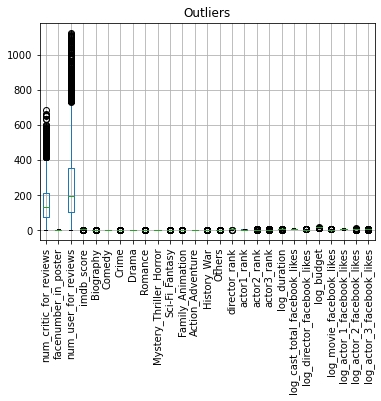

In [153]:
X_data = movie_log_df.drop(columns=['gross','gross_budget_ratio', 'content_rating'])
X_data_no_voted_out = X_data[(np.abs(stats.zscore(X_data['num_voted_users'], nan_policy='omit')) < 3)]
#X_data_no_voted_out = X_data[(np.abs(stats.zscore(X_data['num_critic_for_reviews'], nan_policy='omit')) < 3)]

y = pd.qcut(X_data_no_voted_out['log_gross_budget_ratio'], q=2, labels=False)

X_data_no_voted_out = X_data_no_voted_out.drop(columns=['log_gross_budget_ratio'])

X_data_no_num_voted_users.boxplot()
plt.xticks(rotation='vertical')
plt.title("Outliers")
plt.show()

Test score: 0.748178980228928
Test accuracy: 0.7481789802289281


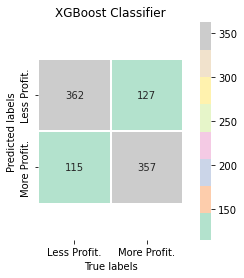

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no_voted_out, y, test_size=0.3, random_state=7)

model1 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

train_model1 = model1.fit(X_train, y_train)

pred1 = train_model1.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score

print(f"Test score: {f1_score(y_test, pred1, average='micro')}")
print(f"Test accuracy: {accuracy_score(y_test, pred1)}")

ax = plt.subplot()
Model_Confusion_Matrix = confusion_matrix(pred1,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Less Profit.","More Profit."])
ax.yaxis.set_ticklabels(["Less Profit.","More Profit."], va="center")
b, t = plt.ylim() 
b += .5
t -= 0.5
plt.ylim(b, t)
plt.title('XGBoost Classifier')
plt.show()

**This is goos :)**

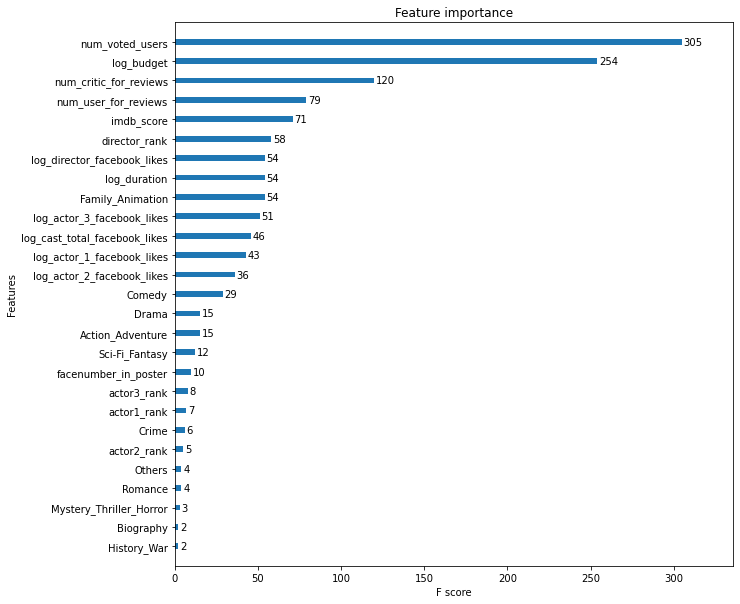

In [172]:
from xgboost import plot_importance

ax = plot_importance(best_clf, height=0.3, grid=False)
fig = ax.figure
fig.set_size_inches(10, 10)